In [1]:
import networkx as nx
import scipy.integrate as integrate 
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import math
import time
import pickle

import TransportationNetworks as tn
from heapq import heappush, heappop
from itertools import count

In [2]:
class Run:
    def __init__(self, link_file, trip_file, node_file, SO=True):
        
        nw = tn.Network(link_file, trip_file, node_file, SO)
        self.od_vols = nw.od_vols

        ## initialization
        self.network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
                   'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
                   'auxiliary':[], 'cost':[]} for (u, v, d) in nw.graph.edges(data=True)}
        
        self.fwResult = {'theta':[], 'z':[]}
        
        nw.all_or_nothing_assignment()
        nw.update_linkcost()
        
        for linkKey, linkVal in self.network.items():
            linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
            linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            linkVal['flow'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
            
        ## iterations
        iterNum=0
        iteration = True
        start = time.time()
        PERIOD_OF_TIME = 900 # 15min

        while iteration:
            iterNum += 1
            nw.all_or_nothing_assignment()
            nw.update_linkcost()
            
            for linkKey, linkVal in self.network.items():
                linkVal['auxiliary'].append(nw.graph[linkKey[0]][linkKey[1]]['object'].vol)
                
            theta = self.lineSearch()
            self.fwResult['theta'].append(theta)
            
            for linkKey, linkVal in self.network.items():
                aux = linkVal['auxiliary'][-1]
                flow = linkVal['flow'][-1]
                linkVal['flow'].append(flow + theta*(aux-flow))
                
                nw.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
                nw.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
                
            
            nw.update_linkcost()
            
            z=0
            for linkKey, linkVal in self.network.items():
                linkVal['cost'].append(nw.graph[linkKey[0]][linkKey[1]]['weight'])
                totalcost = nw.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
                z+=totalcost
                
            self.fwResult['z'].append(z)        
            
            if iterNum == 1:
                iteration = True
            else:
                print(iterNum)
                if abs(self.fwResult['z'][-2] - self.fwResult['z'][-1]) <= 0.001 or \
                   iterNum==1000 or \
                   time.time() > start + PERIOD_OF_TIME:
                    iteration = False
                
        print(iterNum, self.fwResult['z'][-1])
        self.graph = nw.graph
                    
    def BPR(self, t0, xa, ca, alpha, beta):
        ta = t0 * (1 + alpha * pow((xa/ca), beta))
        return ta
    
    def calculateZ(self, theta):
        z = 0
        for linkKey, linkVal in self.network.items():
            t0 = linkVal['t0']
            ca = linkVal['capa']
            beta = linkVal['beta']
            alpha = linkVal['alpha']
            aux = linkVal['auxiliary'][-1]
            flow = linkVal['flow'][-1]
            
            if SO == False:
                z += integrate.quad(lambda x: self.BPR(t0, x, ca, alpha, beta), 0, flow+theta*(aux-flow))[0]
            elif SO == True:
                z += list(map(lambda x : x * self.BPR(t0, x, ca, alpha, beta), [flow+theta*(aux-flow)]))[0]
        return z
    
    def lineSearch(self):
        theta = minimize_scalar(lambda x: self.calculateZ(x), bounds = (0,1), method = 'Bounded')
        return theta.x
    
    
    def shortest_successive_path(self, source, target, SO):
        if target == source:
            return [target]

        paths = {source: [source], target: []} # dictionary of paths
        G_succ = self.graph._succ
        push = heappush
        pop = heappop        
        dist = {}  # dictionary of final width
        c = count() # use the count c to avoid comparing nodes
        fringe = [] # fringe is min heapq with 3-tuples (distance,c,node)

        for n in self.graph.nodes:
            dist[n] = float('inf')
        dist[source] = 0
        
        push(fringe, (dist[source], next(c), source))
        while fringe:
            (w, _, v) = pop(fringe)
            if v == target:
                break

            for u, e in G_succ[v].items():
                # Check for only those edges who have enough capacity left
                if e['capacity'] > 0:
                    if SO == True:
                        dist_vu = e['weight']
                    else:
                        dist_vu = e['object'].length
                    alt = dist[v] + dist_vu

                    if alt < dist[u]:
                        dist[u] = alt
                        push(fringe, (dist[u], next(c), u))
                        paths[u] = paths[v] + [u]

        return paths[target]

    
    def showODPath(self, SO):
        capacity = dict()
        for (u, v, d) in self.graph.edges(data=True):
            capacity[(u,v)] = math.ceil(d['object'].vol)

        nx.set_edge_attributes(self.graph, capacity, name='capacity')

        # Decomposing flow into a path for every request
        infeasible = dict()
        cost = 0
        count = 0

        for ((origin, dest), demand) in self.od_vols.items():
            while demand > 0:
                path = self.shortest_successive_path(origin, dest, SO)

                if path == []: # Add to waiting queue
                    infeasible[(origin, dest)] = demand
                    break
                else:
                    # Decrement capacity of chosen path by 1
                    for i in range(len(path)-1):
                        u = path[i]
                        v = path[i+1]
                        self.graph[u][v]['capacity'] -= 1
                        cost += self.graph[u][v]['weight']
                    demand = demand - 1

        # Route infeasible paths in a user equilibrium way
        if len(infeasible) > 0:
            new_capacity = dict()

            for (u, v, d) in self.graph.edges(data=True):
                new_capacity[(u,v)] = d['object'].capacity -\
                                      math.ceil(d['object'].vol) +\
                                      d['capacity']

            nx.set_edge_attributes(self.graph, new_capacity, name='capacity')
            
            for (origin, dest), demand in infeasible.items():
                while demand > 0:
                    path = self.shortest_successive_path(origin, dest, SO)

                    if path == []: # Add to waiting queue
                        count += demand
                        break
                    else:
                        # Decrement capacity of chosen path by 1
                        for i in range(len(path)-1):
                            u = path[i]
                            v = path[i+1]
                            self.graph[u][v]['capacity'] -= 1
                            cost += self.graph[u][v]['weight']
                        demand = demand - 1   

        print("No. of infeasible trips:", count)
        print("Cost:", cost)
        return (count, cost)

In [3]:
node_file = '../data/TNTP/Singapore_node.tntp'

## Off-peak

In [26]:
link_file = '../data/TNTP/Singapore_net_off.tntp'
with open ('data/ped_off.pkl', 'rb') as fp:
    ped_off = pickle.load(fp)

In [5]:
# System Equilibrium = Multi-Class + System optimal flows + Congestion-aware routes
SO = True
trip_file = '../data/Demand/Singapore_trips_500_high.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_off, s_cost_off) = fw.showODPath(SO)
s_cost_off += sum(ped_off)*5 - s_count_off*sum(ped_off)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
132 1376533.9692297103
No. of infeasible trips: 1.0
Cost: 1725236.2277823284


In [6]:
# User Equilibrium = Single-Class + User optimal flows + Shortest-path routes
SO = False
trip_file = '../data/Demand/Singapore_trips_500.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_off, u_cost_off) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
42 3847403.8238859465
No. of infeasible trips: 53.0
Cost: 4716308.473948144


## Mod-peak

In [7]:
link_file = '../data/TNTP/Singapore_net_mod.tntp'
with open ('data/ped_mod.pkl', 'rb') as fp:
    ped_mod = pickle.load(fp)

In [8]:
# System Equilibrium
SO = True
trip_file = '../data/Demand/Singapore_trips_500_mod.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_mod, s_cost_mod) = fw.showODPath(SO)
s_cost_mod += sum(ped_mod)*5 - s_count_mod*sum(ped_mod)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
122 1499101.6237761043
No. of infeasible trips: 1.0
Cost: 2393870.612389199


In [9]:
# User Equilibrium
SO = False
trip_file = '../data/Demand/Singapore_trips_500.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_mod, u_cost_mod) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
43 3968705.7407535254
No. of infeasible trips: 43.0
Cost: 5092681.476744859


## High-peak

In [10]:
link_file = '../data/TNTP/Singapore_net_high.tntp'
with open ('data/ped_high.pkl', 'rb') as fp:
    ped_high = pickle.load(fp)

In [11]:
# System Equilibrium
SO = True
trip_file = '../data/Demand/Singapore_trips_500_high.tntp'
fw = Run(link_file, trip_file, node_file, SO)

(s_count_high, s_cost_high) = fw.showODPath(SO)
s_cost_high += sum(ped_high)*5 - s_count_high*sum(ped_high)/100

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
128 1324136.1095119002
No. of infeasible trips: 1.0
Cost: 1425721.3814603465


In [12]:
# User Equilibrium
SO = False
trip_file = '../data/Demand/Singapore_trips_500.tntp'
fw = Run(link_file, trip_file, node_file, SO)
(u_count_high, u_cost_high) = fw.showODPath(SO)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
42 4011549.713709648
No. of infeasible trips: 43.0
Cost: 5357088.716186852


## Plot!

In [1]:
import numpy as np

s_waiting_queue = [s_count_off, s_count_mod, s_count_high] 
u_waiting_queue = [u_count_off, u_count_mod, u_count_high]

# s_tt_cost = [s_cost_off, s_cost_mod, s_cost_high]
# u_tt_cost = [u_cost_off, u_cost_mod, u_cost_high]

s_ft_cost = [1376533.9692297103, 1499101.6237761043, 1324136.1095119002]
u_ft_cost = [3847403.8238859465, 3968705.7407535254, 4011549.713709648]

labels = ["Off-Peak(12:00 A.M.)", "Moderately-Peak(3:00 P.M.)", "High-Peak(6:00 P.M.)"]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

def autolabel(rects, ax, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(math.ceil(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom')

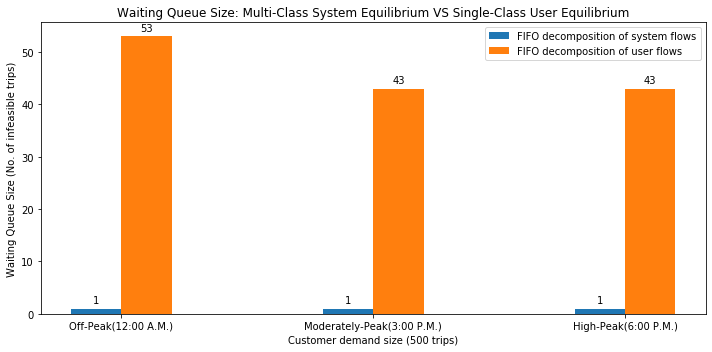

In [23]:
fig1, ax1 = plt.subplots(figsize=(10,5))
rects1 = ax1.bar(x - width/2, s_waiting_queue, width, label='FIFO decomposition of system flows')
rects2 = ax1.bar(x + width/2, u_waiting_queue, width, label='FIFO decomposition of user flows')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Waiting Queue Size (No. of infeasible trips)')
ax1.set_xlabel('Customer demand size (500 trips)')
ax1.set_title('Waiting Queue Size: Multi-Class System Equilibrium VS Single-Class User Equilibrium')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

autolabel(rects1, ax1)
autolabel(rects2, ax1)
fig1.tight_layout()

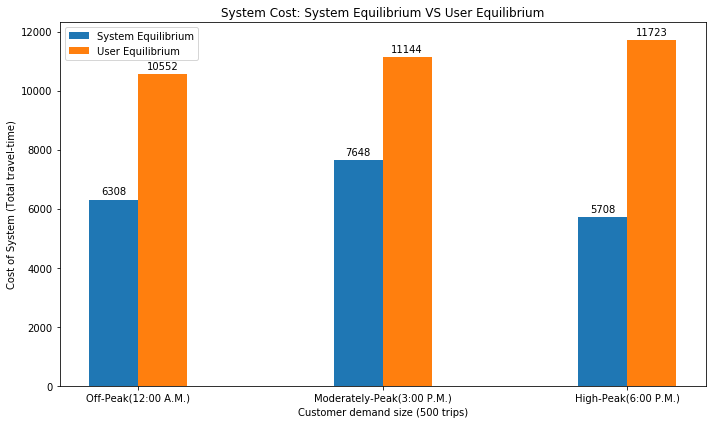

In [2]:
import matplotlib.pyplot as plt
import math
s_tt_cost = [3147347/((500-1)), 3815981/((500-1)), 2847832/((500-1))]
u_tt_cost = [4716309/((500-53)), 5092682/((500-43)), 5357089/((500-43))]

fig2, ax2 = plt.subplots(figsize=(10,6))
rects3 = ax2.bar(x - width/2, s_tt_cost, width, label='System Equilibrium')
rects4 = ax2.bar(x + width/2, u_tt_cost, width, label='User Equilibrium')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Cost of System (Total travel-time)')
ax2.set_xlabel('Customer demand size (500 trips)')
ax2.set_title('System Cost: System Equilibrium VS User Equilibrium')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

autolabel(rects3, ax2)
autolabel(rects4, ax2)
fig2.tight_layout()

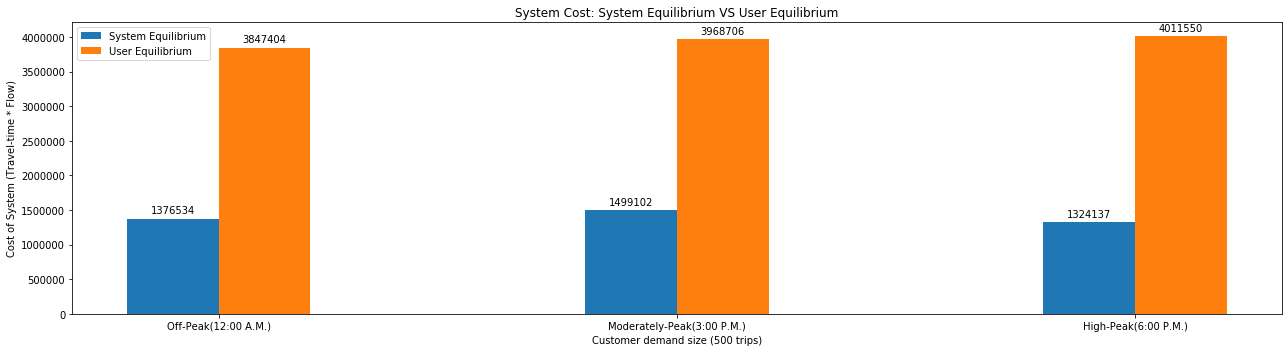

In [34]:
fig3, ax3 = plt.subplots(figsize=(18,5))
rects5 = ax3.bar(x - width/2, s_ft_cost, width, label='System Equilibrium')
rects6 = ax3.bar(x + width/2, u_ft_cost, width, label='User Equilibrium')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax3.set_ylabel('Cost of System (Travel-time * Flow)')
ax3.set_xlabel('Customer demand size (500 trips)')
ax3.set_title('System Cost: System Equilibrium VS User Equilibrium')
ax3.set_xticks(x)
ax3.set_xticklabels(labels)
ax3.legend(loc='upper left')

autolabel(rects5, ax3)
autolabel(rects6, ax3)
fig3.tight_layout()

In [35]:
import osmnx as ox
G = ox.save_load.load_graphml(filename="Central_SG_drive.graphml")
edges_central = ox.graph_to_gdfs(G, nodes=False, edges=True)

In [45]:
u_cen = edges_central['u']
v_cen = edges_central['v']

In [50]:
def open_link_file(link_file):
        link_fields = {"from": 1, "to": 2, "capacity": 3, "length": 4, "t0": 5, \
                   "B": 6, "beta": 7, "V": 8}
        
        f = open(link_file)
        lines = f.readlines()
        f.close()

        links_info = []

        header_found = False
        for line in lines:
            if not header_found and line.startswith("~"):
                header_found = True
            elif header_found:
                links_info.append(line)
                
        capa = dict()

        for line in links_info:
            data = line.split("\t")

            try:
                origin_node = int(data[link_fields["from"]])
            except IndexError:
                continue
            to_node = int(data[link_fields["to"]])
            capacity = float(data[link_fields["capacity"]])

            capa[(origin_node, to_node)] = capacity
        return capa

In [51]:
capa_off = open_link_file('../data/TNTP/Singapore_net_off.tntp')
capa_mod = open_link_file('../data/TNTP/Singapore_net_mod.tntp')
capa_high = open_link_file('../data/TNTP/Singapore_net_high.tntp')

In [61]:
capacity = 0
for (u,v) in zip(u_cen, v_cen):
    try:
        capacity += capa_off[(u,v)]
    except KeyError:
        continue
print(capacity)

1505472.0


In [62]:
capacity = 0
for (u,v) in zip(u_cen, v_cen):
    try:
        capacity += capa_mod[(u,v)]
    except KeyError:
        continue
print(capacity)

1285669.0


In [63]:
capacity = 0
for (u,v) in zip(u_cen, v_cen):
    try:
        capacity += capa_high[(u,v)]
    except KeyError:
        continue
print(capacity)

1277183.0


In [64]:
capacity = 0
for x,c in capa_off.items():
    capacity += c
print(capacity)

6867931.0


In [65]:
capacity = 0
for x,c in capa_mod.items():
    capacity += c
print(capacity)

5678012.0


In [66]:
capacity = 0
for x,c in capa_high.items():
    capacity += c
print(capacity)

5519274.0
